# Required modules
- PyYAML
- pyorient

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from appconfig import AppConfig, DataFileContainer
from stockdatabase import StockDatabase
from statistics import TimeRange, IndexTimeRanges
import statistics as st
import constants as c
import pandas as pd
import os
import matplotlib.pyplot as plt
import operator
import json

# Load information from config files

In [3]:
config = AppConfig("config/config.yml")
data_file_list = DataFileContainer("config/files.yml")

# Setup database (connect and create table and primary key fields)

In [4]:
database = StockDatabase(config.database_user, config.database_password, config.database_name,
                         config.database_host, config.database_port, config.table_index_values_name)
database.connect()
database.recreate_tables()

# Insert all index values from csv files

In [5]:
def batch_insert_index_values_from_files(database, index_file_folder_path, file_list):
    print("-- Inserting index values")
    current_index = 1
    for file in file_list:
        path = os.path.join(index_file_folder_path, file["file_name"])
        df = pd.read_csv(path)
        print("Inserting '" + file["file_name"] + "' (" + str(current_index) +
              " of " + str(len(file_list)) + ") (" + str(df.shape[0]) + " rows) ...")
        current_index += 1
        database.insert_index_values(df, file["isin"])
    print("-- Done!")

batch_insert_index_values_from_files(database, config.data_file_folder, data_file_list.index_value_files)

-- Inserting index values
Inserting 'Index CAC40 (FCHI) Entwicklung.csv' (1 of 5) (8088 rows) ...
Inserting 'Index DAX Entwicklung.csv' (2 of 5) (8623 rows) ...
Inserting 'Index Dow Jones (DJI) Entwicklung.csv' (3 of 5) (7425 rows) ...
Inserting 'Index Euronext 100 (N100) Entwicklung.csv' (4 of 5) (5522 rows) ...
Inserting 'Index S&P500 Entwicklung.csv' (5 of 5) (12986 rows) ...
-- Done!


# Test query (check if any values in database)

In [6]:
print(database.query_index_values("DE0008469008", limit=1)[0].__dict__)

{'date': datetime.date(1987, 12, 30), 'open': 1005.190002, 'close': 1005.190002}


# Display development chart for the DAX (ISIN: DE0008469008)

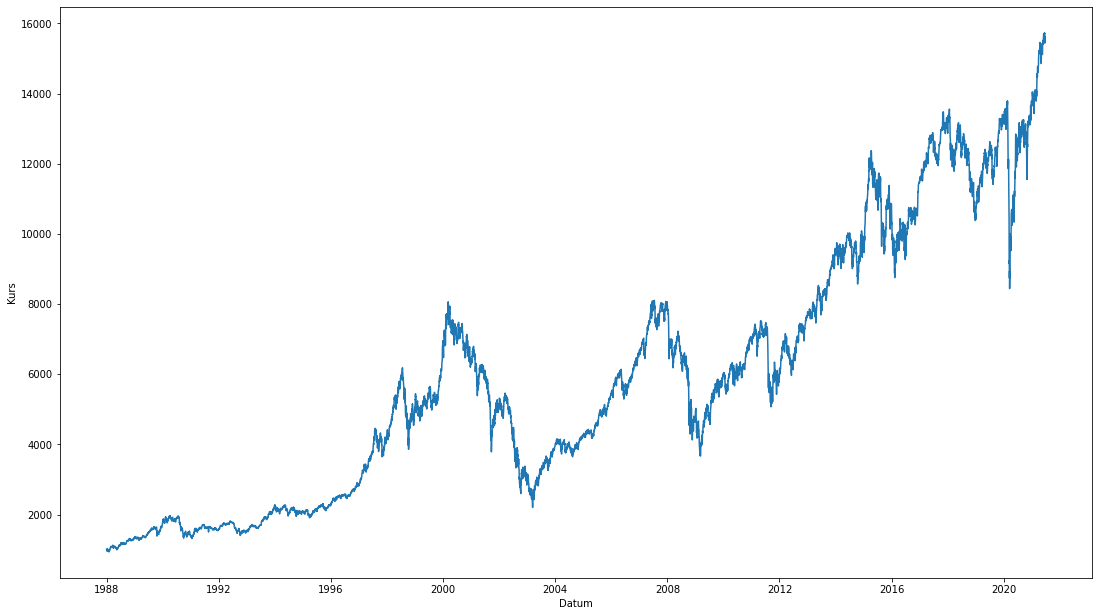

In [7]:
dax_data = database.query_index_values("DE0008469008")

dates = list([s.date for s in dax_data])
close_values = list([s.close for s in dax_data])

plt.plot(dates, close_values)
plt.xlabel('Datum')
plt.ylabel('Kurs')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

# Create a weekday statistic

In [8]:
data = database.query_index_values("US78378X1072")

weekday_statistic = st.create_weekday_statistic(data)
[x.__dict__ for x in weekday_statistic]

[{'weekday': 0,
  'count': 2465,
  'days_positive': 1272,
  'days_negative': 1193,
  'total_positive': 8752.11932900001,
  'total_negative': -8340.473192000003,
  'days_ratio': 1.066219614417435,
  'total_ratio': 1.0493552496991236},
 {'weekday': 1,
  'count': 2657,
  'days_positive': 1370,
  'days_negative': 1287,
  'total_positive': 9697.510896999998,
  'total_negative': -8252.469615000002,
  'days_ratio': 1.0644910644910646,
  'total_ratio': 1.1751041020948971},
 {'weekday': 2,
  'count': 2661,
  'days_positive': 1478,
  'days_negative': 1183,
  'total_positive': 9207.622285000001,
  'total_negative': -8129.449861000009,
  'days_ratio': 1.2493660185967879,
  'total_ratio': 1.1326255087902548},
 {'weekday': 3,
  'count': 2610,
  'days_positive': 1378,
  'days_negative': 1232,
  'total_positive': 9082.491895999989,
  'total_negative': -8521.073057000001,
  'days_ratio': 1.1185064935064934,
  'total_ratio': 1.0658859318825797},
 {'weekday': 4,
  'count': 2593,
  'days_positive': 1401,


# Plotting the weekday statistic for multiple time ranges

DAX



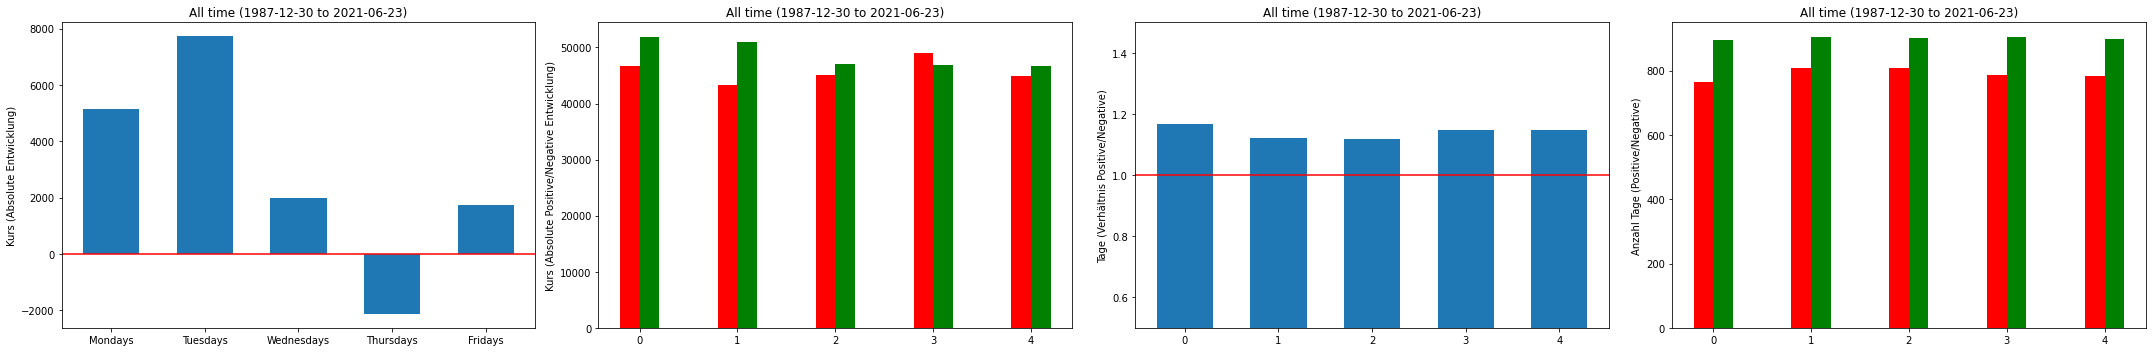

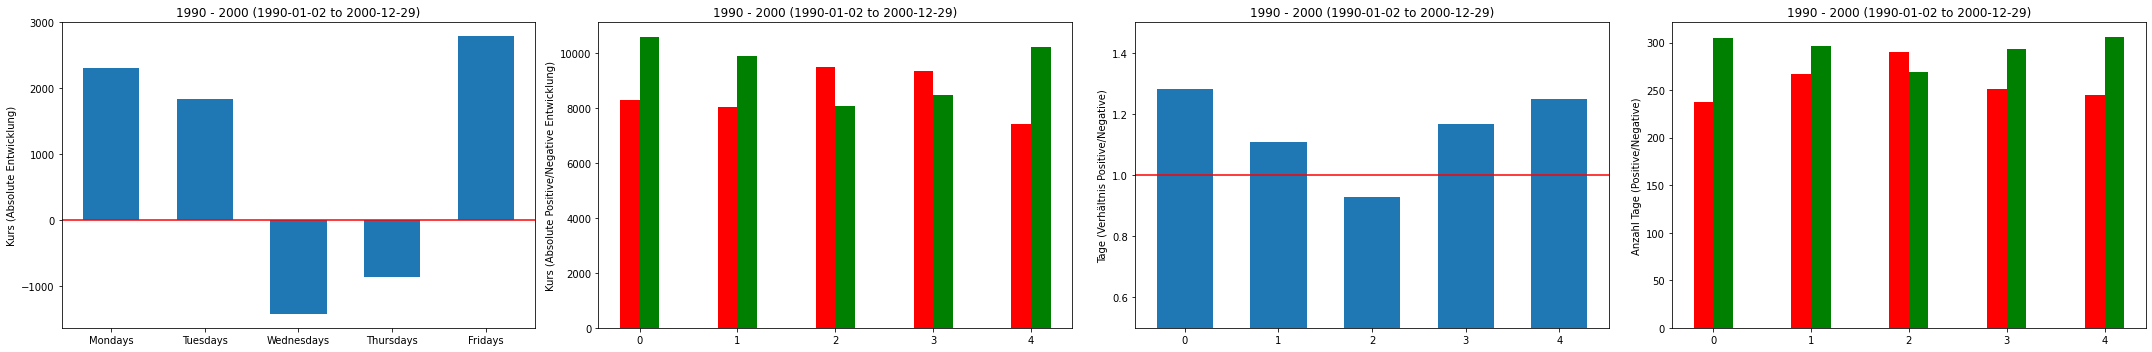

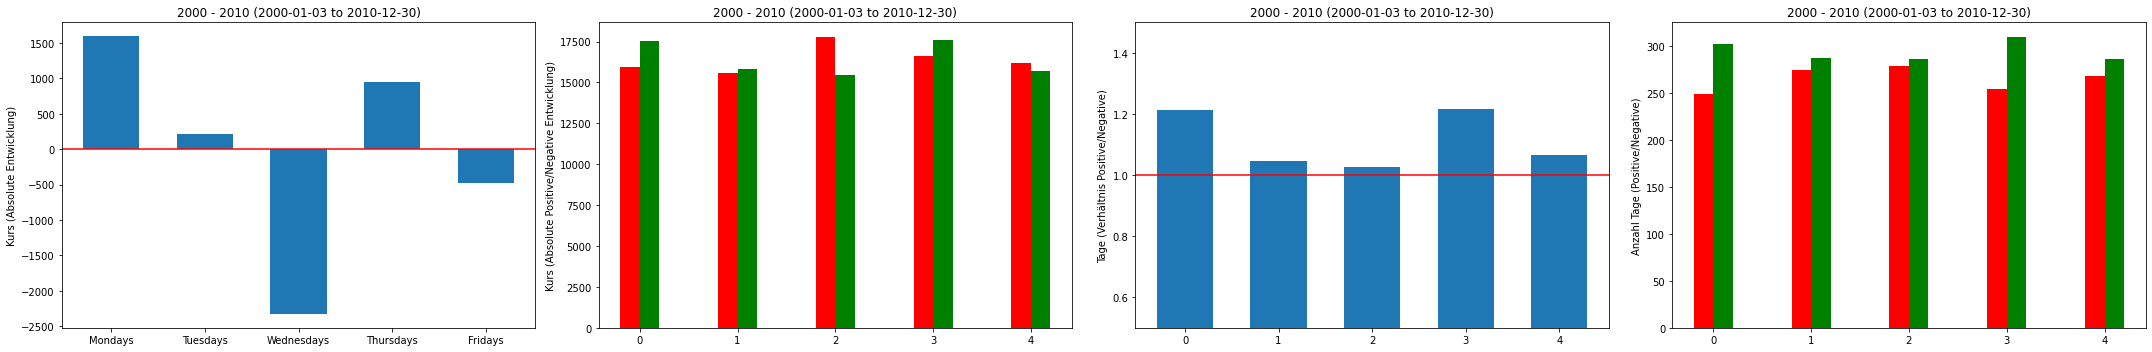

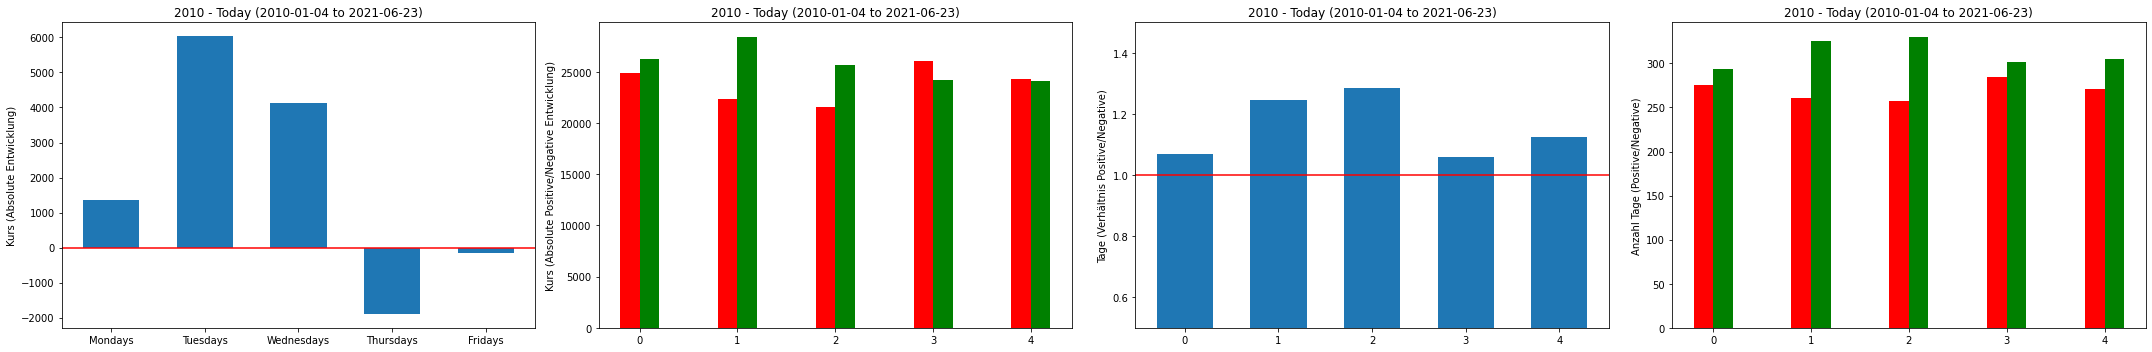

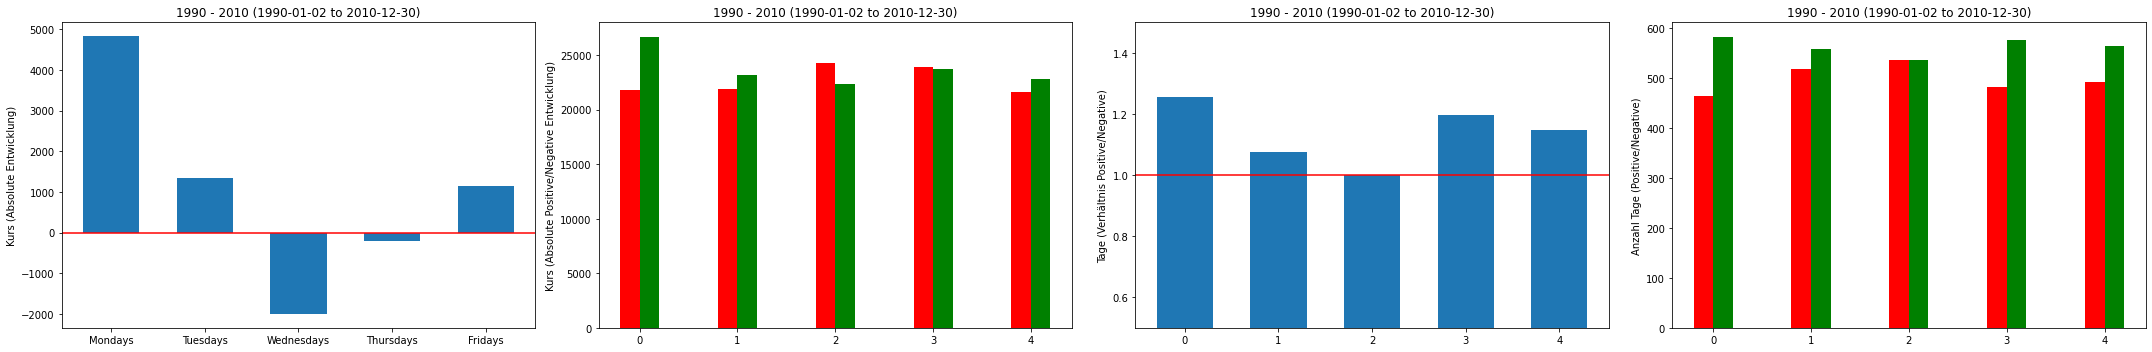

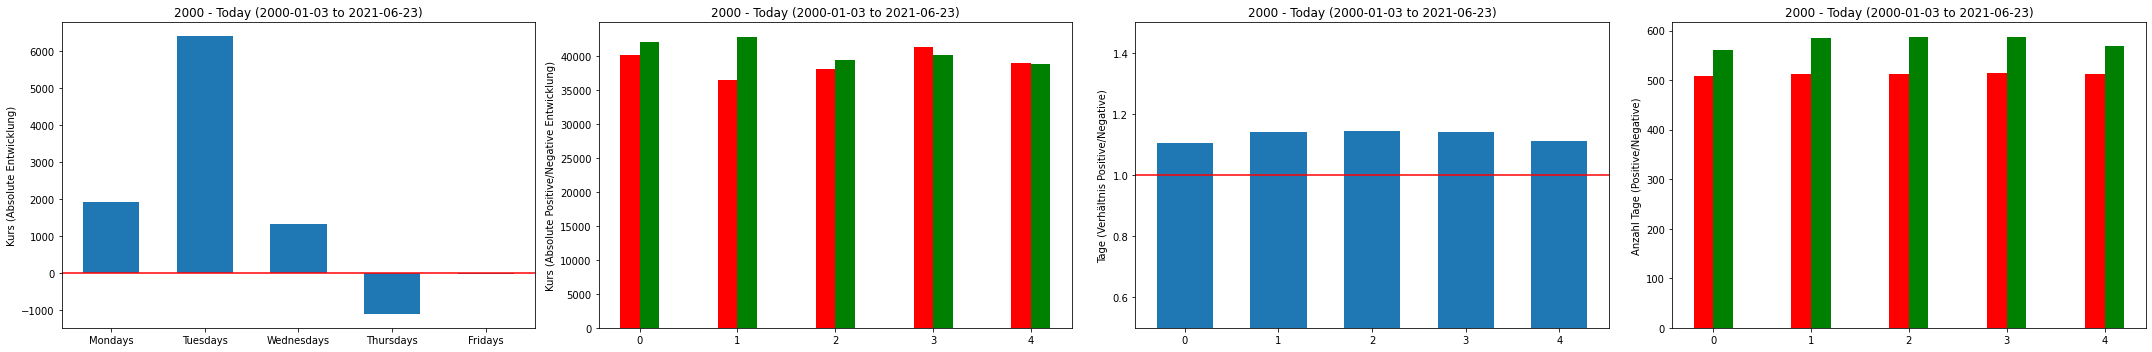


S&P 500



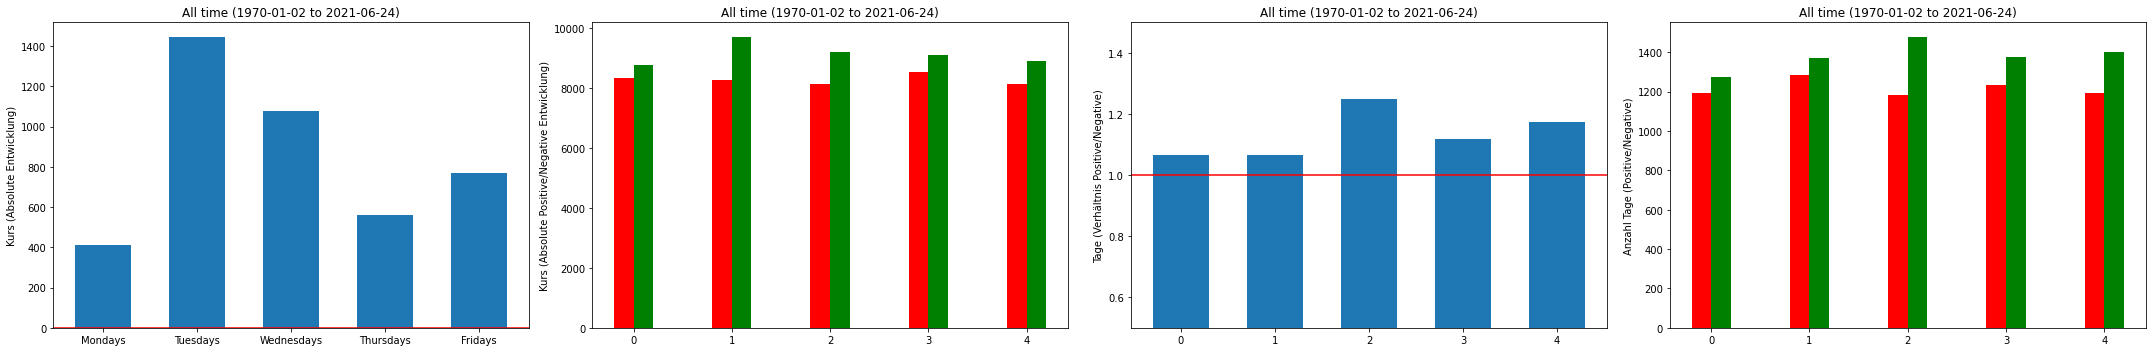

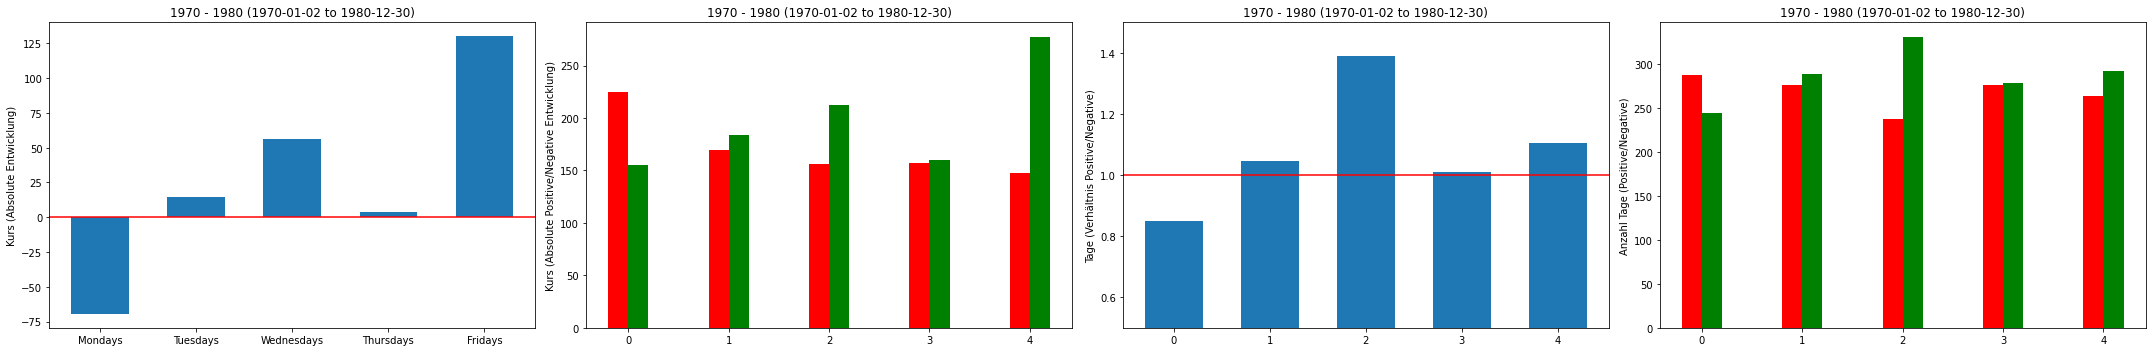

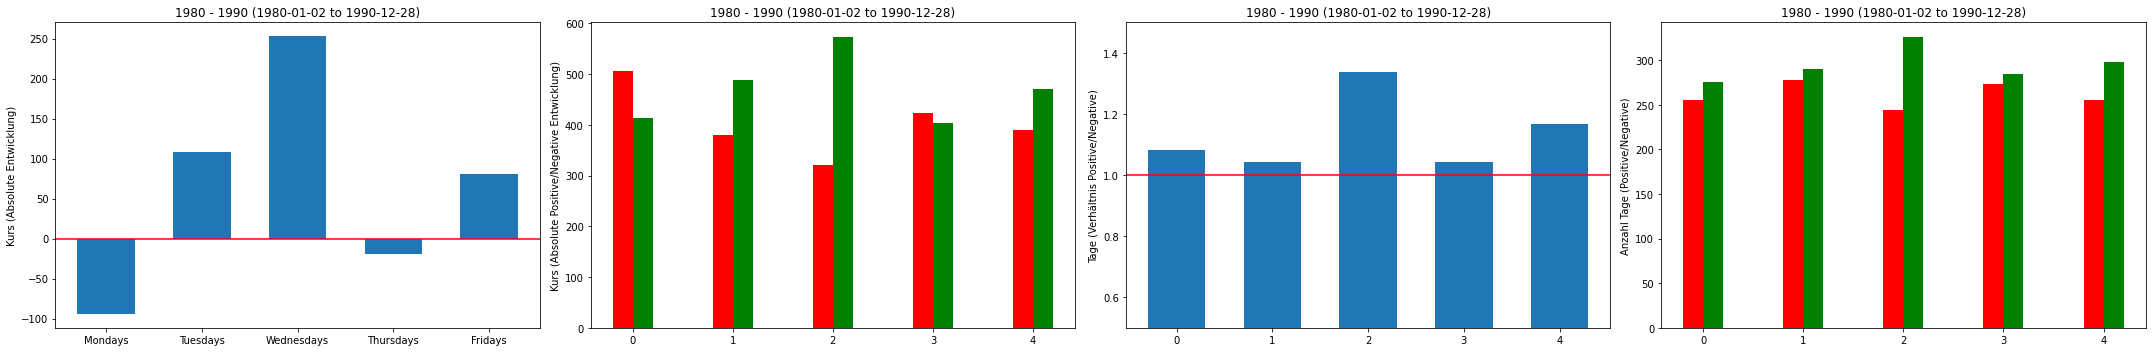

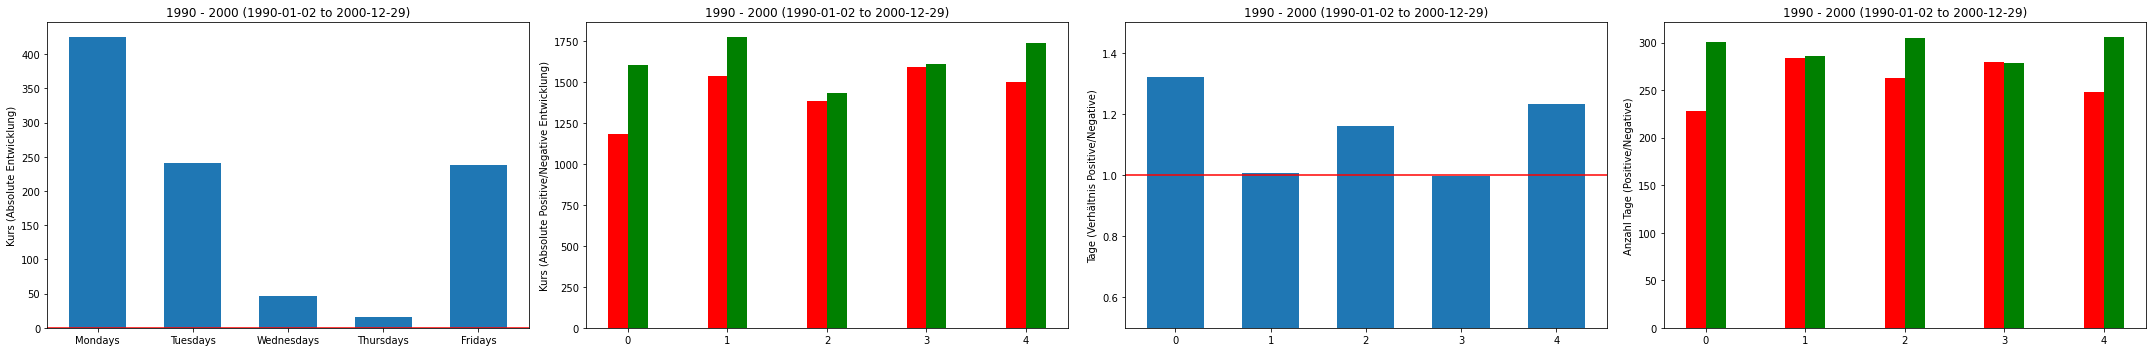

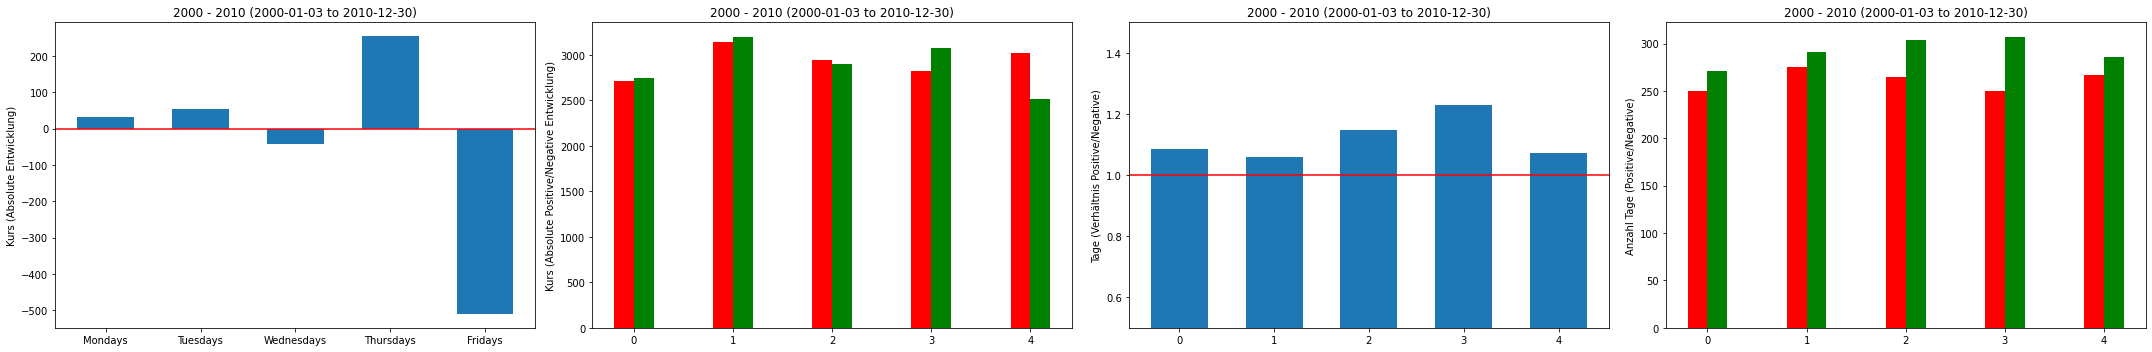

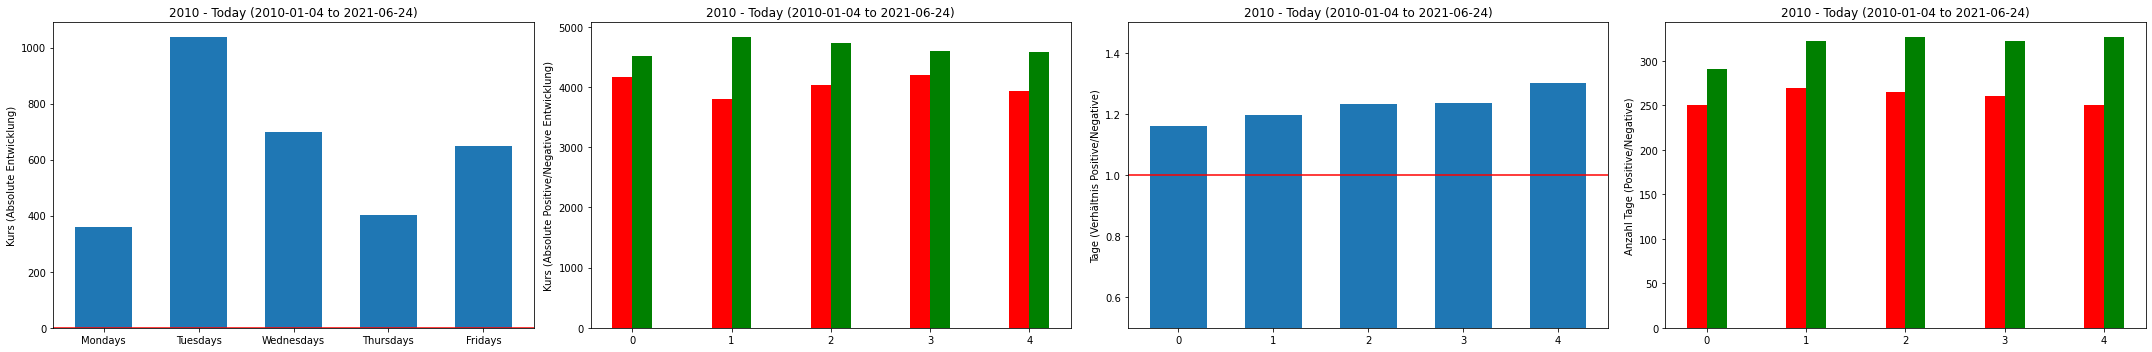


Dow Jones Industrial



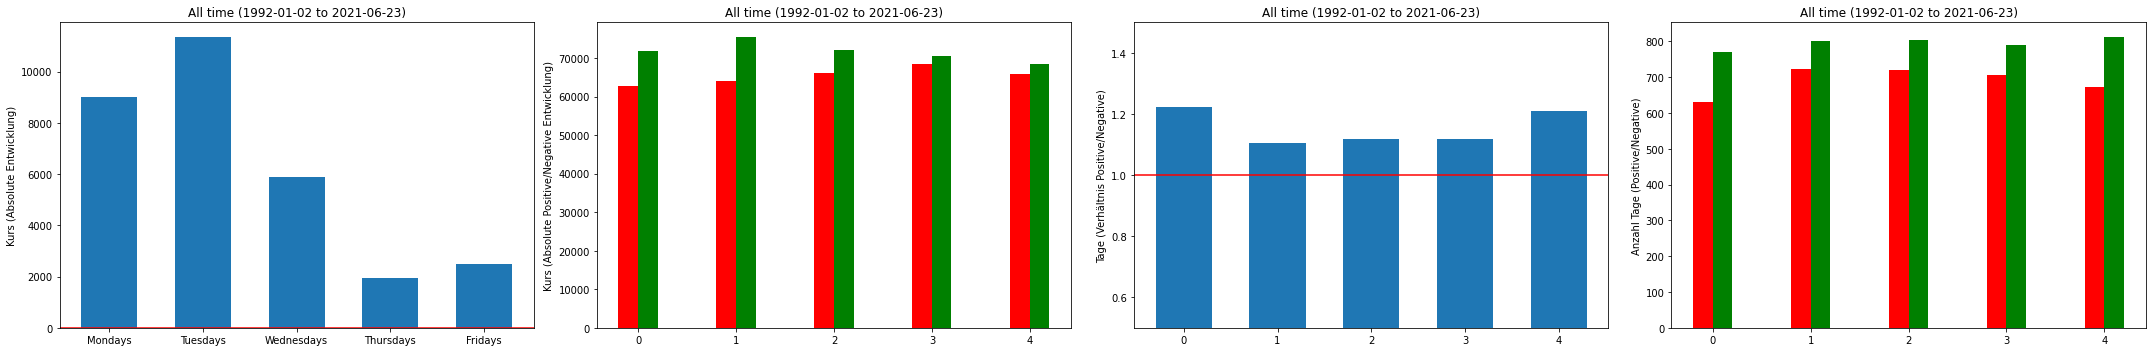

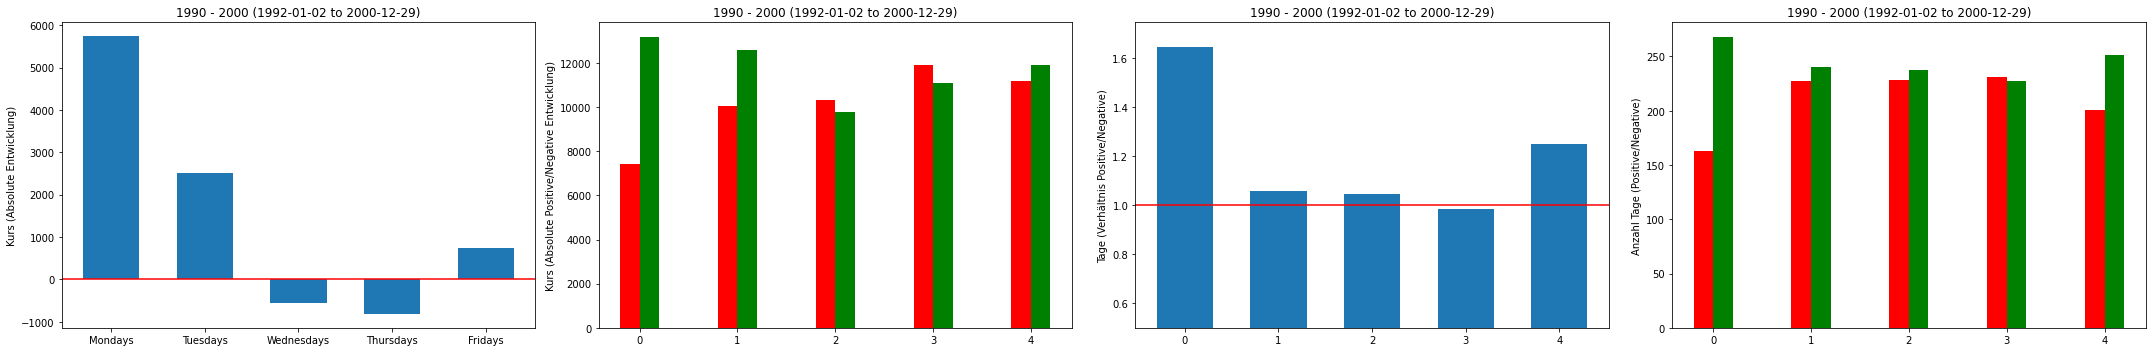

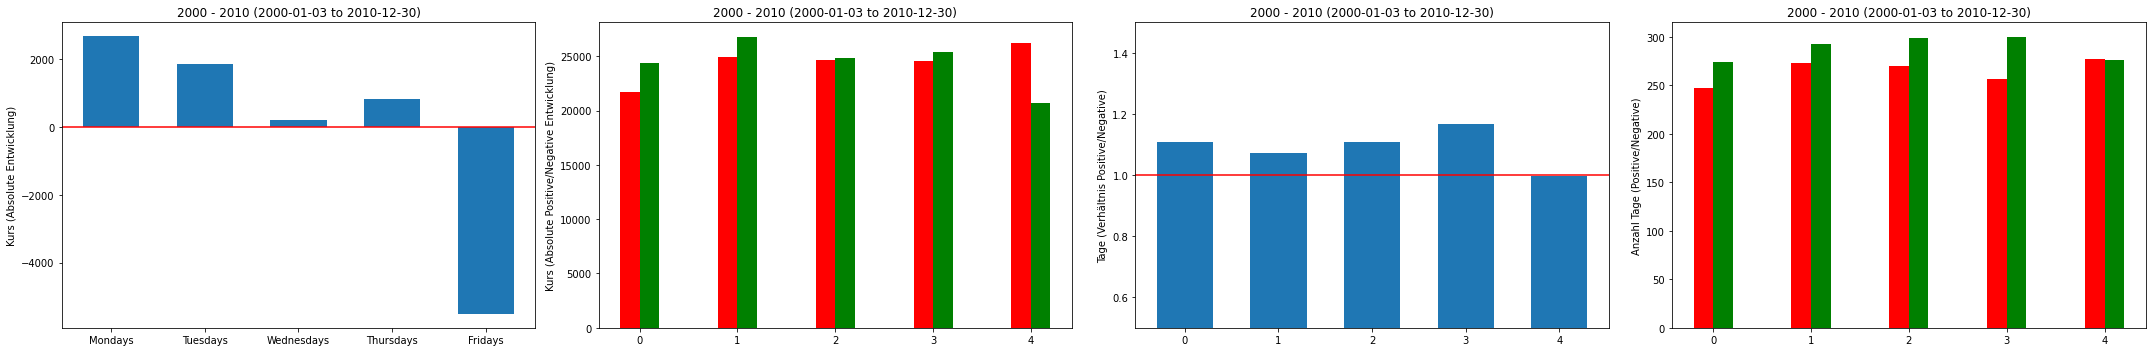

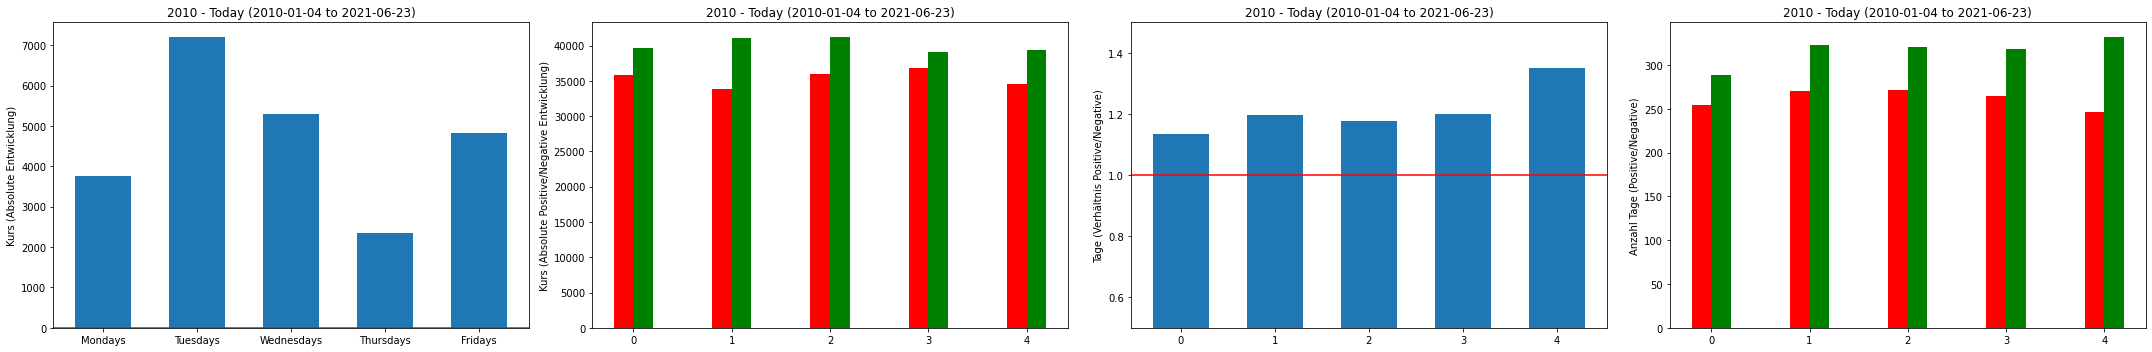


CAC40



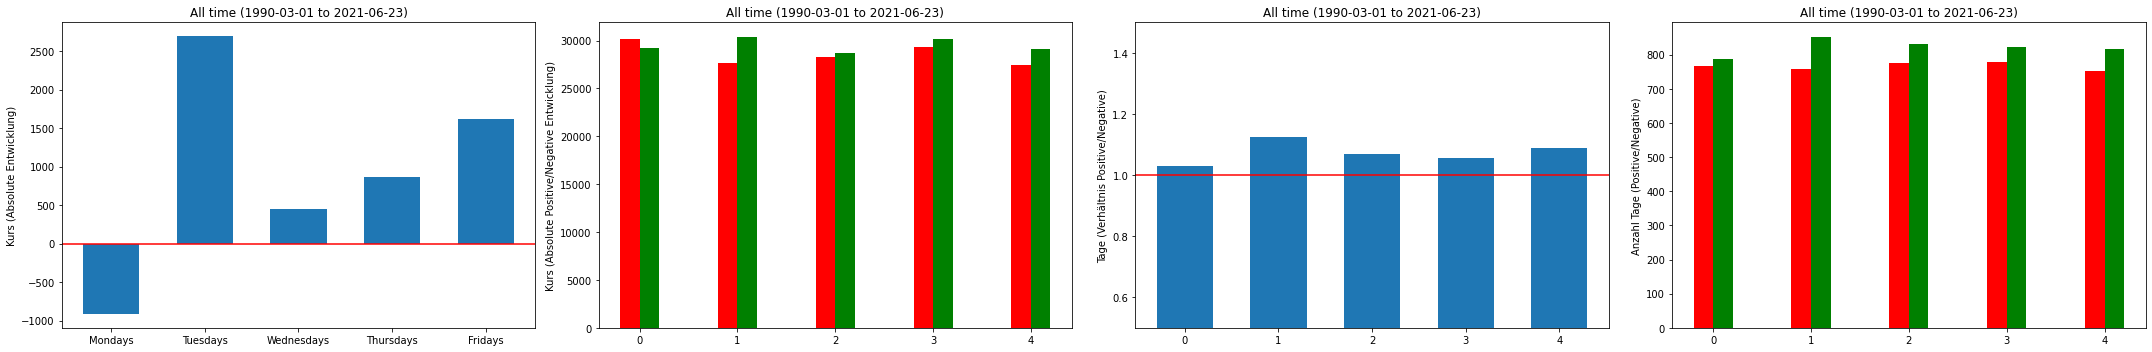

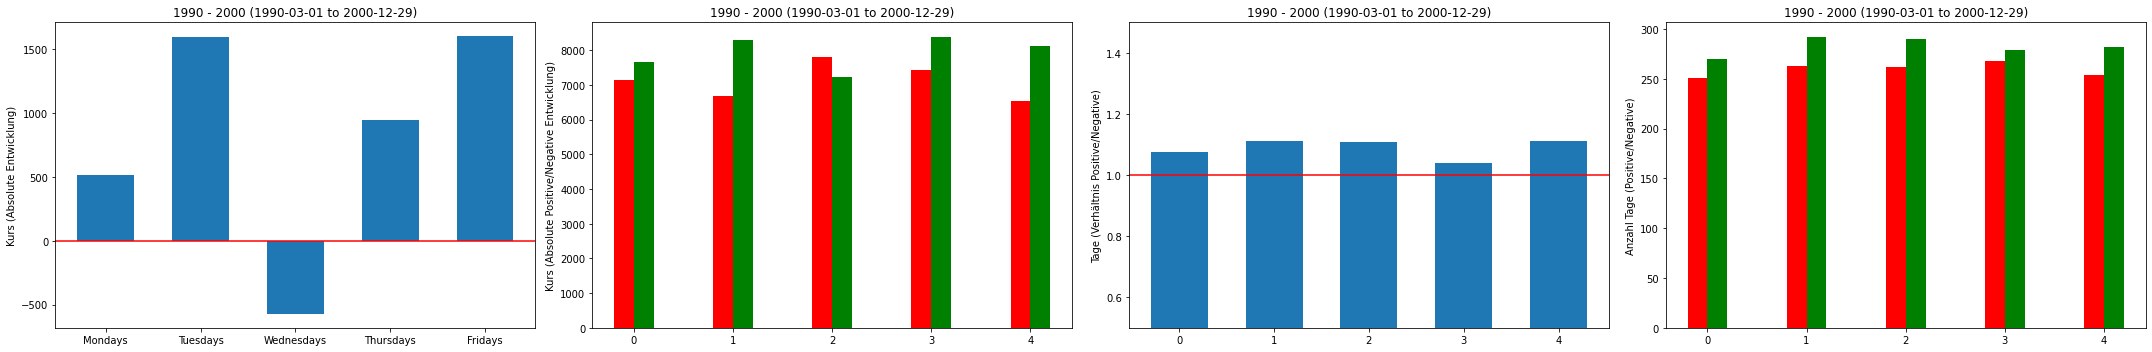

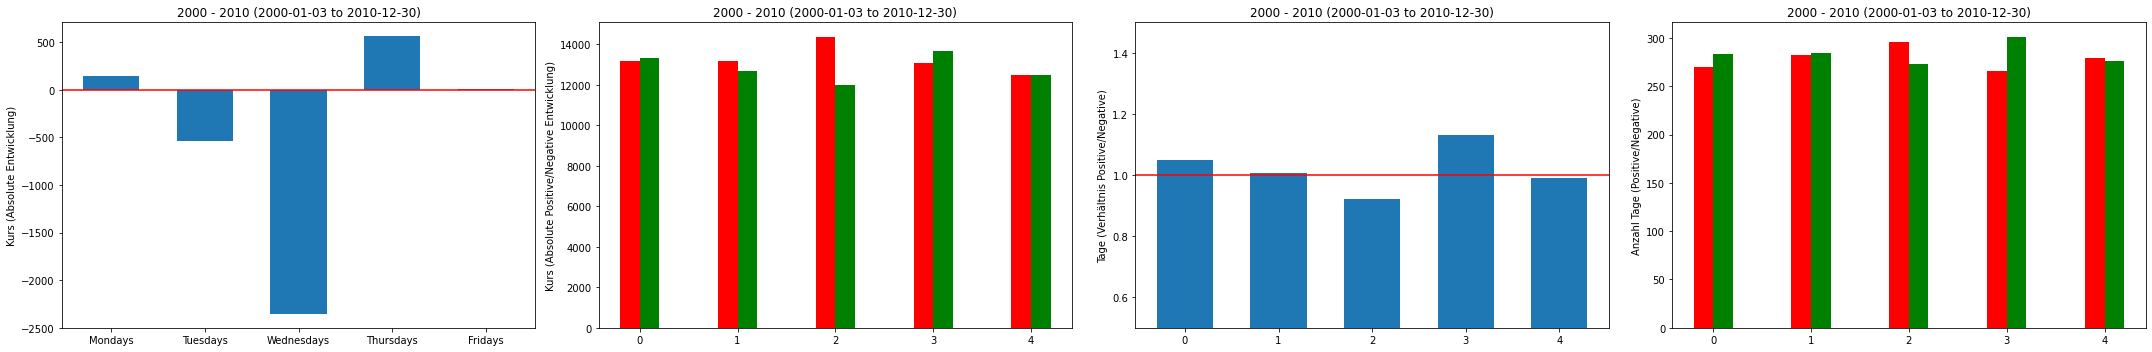

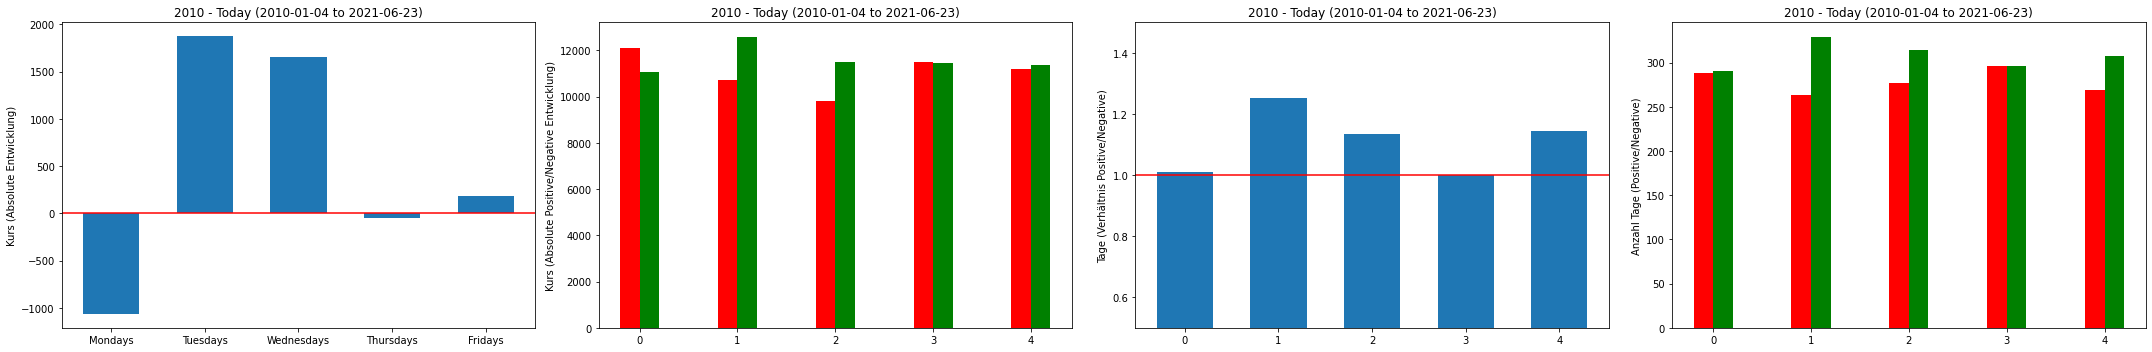


Euronext 100



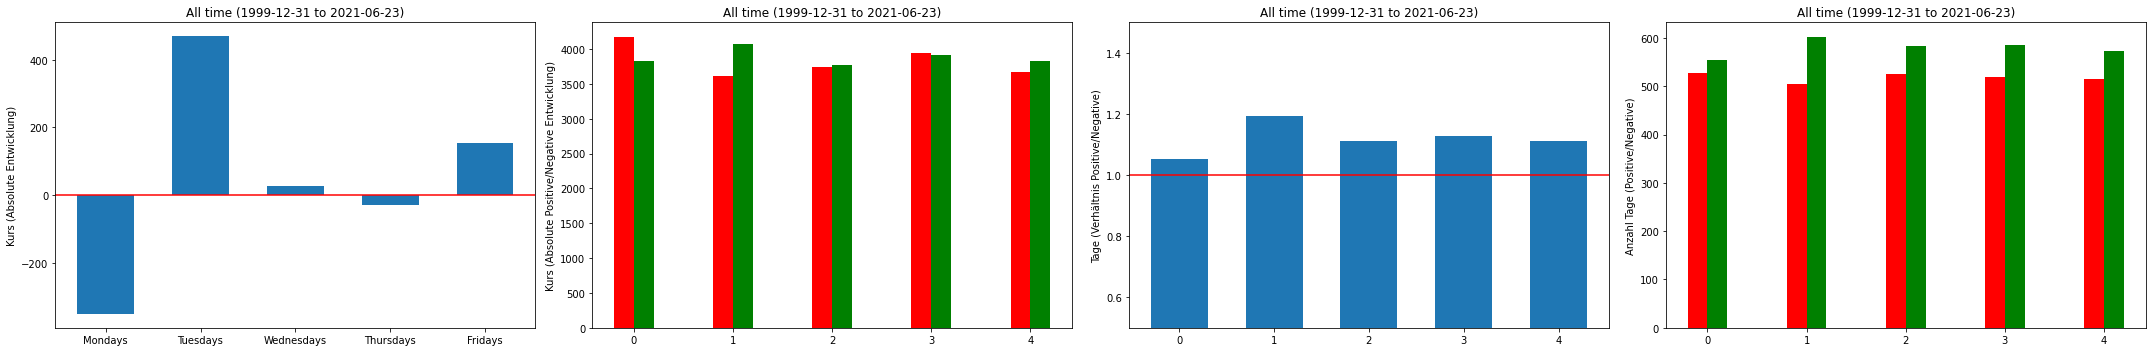

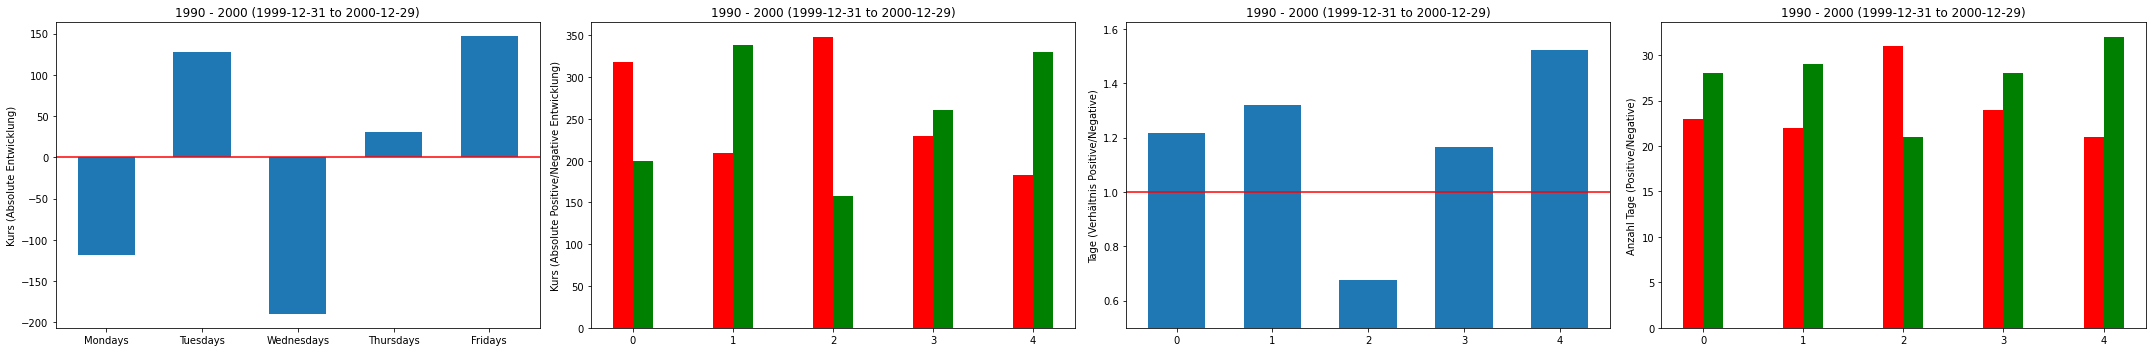

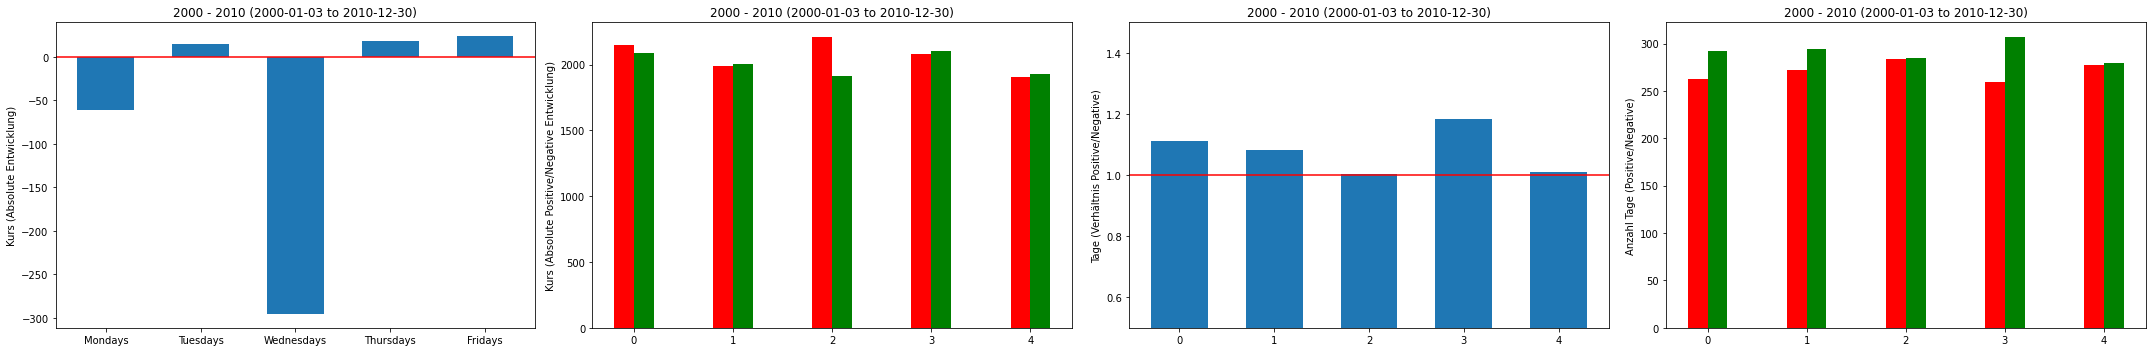

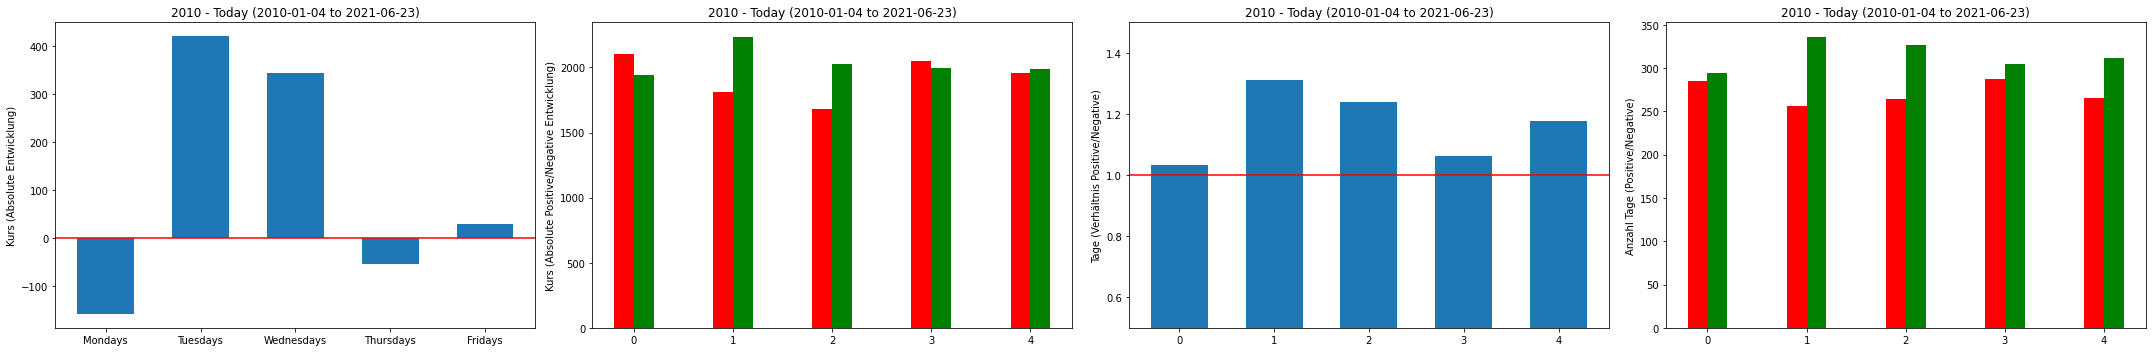

In [9]:
def __get_date_range_as_string(data):
    dates = list([s.date for s in data])
    return '(' + str(min(dates)) + ' to ' + str(max(dates)) + ')'

def query_data_and_plot_all(isin, time_range):
    data = database.query_index_values(isin, time_range.start, time_range.end)
    weekday_statistic = st.create_weekday_statistic(data)

    fig, ax = plt.subplots(ncols=4, figsize=(30, 5))
    
    query_data_and_plot_total(data, weekday_statistic, ax[0])
    query_data_and_plot_pos_neg(data, weekday_statistic, ax[1])
    query_data_and_plot_days_ratio(data, weekday_statistic, ax[2])
    query_data_and_plot_days_total(data, weekday_statistic, ax[3])
    
    plt.tight_layout()
    plt.show()

def query_data_and_plot_total(data, weekday_statistic, ax):
    plt_x = list([c.weekday_names[s.weekday] for s in weekday_statistic])
    plt_values = list([(s.total_positive + s.total_negative) for s in weekday_statistic])

    ax.bar(plt_x, plt_values, color = 'tab:blue', width = 0.6)
    ax.axhline(y=0, color='r', linestyle='-')
    ax.set_ylabel("Kurs (Absolute Entwicklung)")
    ax.set_title(t.name + ' ' + __get_date_range_as_string(data))

def query_data_and_plot_statistic_ratio(data, weekday_statistic, ax):
    plt_x = list([c.weekday_names[s.weekday] for s in weekday_statistic])
    plt_values = list([s.total_ratio for s in weekday_statistic])

    ymin = 0.5 if min(plt_values) >= 0.6 else 0
    ymax = 1.5 if max(plt_values) <= 1.4 else max(plt_values) + 0.1

    ax.bar(plt_x, plt_values, color = 'tab:blue', width = 0.6)
    ax.set_ylim(ymin, ymax)
    ax.axhline(y=1, color='r', linestyle='-')
    ax.set_ylabel("Kurs (Verhältnis Positive/Negative Entwicklung)")
    ax.set_title(t.name + ' ' + __get_date_range_as_string(data))

def query_data_and_plot_pos_neg(data, weekday_statistic, ax):
    plt_x1 = list([s.weekday + 0.1 for s in weekday_statistic])
    plt_x2 = list([s.weekday - 0.1 for s in weekday_statistic])
    plt_y1 = list([s.total_positive for s in weekday_statistic])
    plt_y2 = list([-s.total_negative for s in weekday_statistic])

    ax.bar(plt_x1, plt_y1, width=0.2, color='g', align='center')
    ax.bar(plt_x2, plt_y2, width=0.2, color='r', align='center')
    ax.set_ylabel("Kurs (Absolute Positive/Negative Entwicklung)")
    ax.set_title(t.name + ' ' + __get_date_range_as_string(data))

def query_data_and_plot_days_ratio(data, weekday_statistic, ax):
    plt_x = list([s.weekday for s in weekday_statistic])
    plt_values = list([s.days_ratio for s in weekday_statistic])

    ymin = 0.5 if min(plt_values) >= 0.6 else 0
    ymax = 1.5 if max(plt_values) <= 1.4 else max(plt_values) + 0.1

    ax.bar(plt_x, plt_values, color = 'tab:blue', width = 0.6)
    ax.set_ylim(ymin, ymax)
    ax.axhline(y=1, color='r', linestyle='-')
    ax.set_ylabel("Tage (Verhältnis Positive/Negative)")
    ax.set_title(t.name + ' ' + __get_date_range_as_string(data))

def query_data_and_plot_days_total(data, weekday_statistic, ax):
    plt_x1 = list([s.weekday + 0.1 for s in weekday_statistic])
    plt_x2 = list([s.weekday - 0.1 for s in weekday_statistic])
    plt_y1 = list([s.days_positive for s in weekday_statistic])
    plt_y2 = list([s.days_negative for s in weekday_statistic])

    ax.bar(plt_x1, plt_y1, width=0.2, color='g', align='center')
    ax.bar(plt_x2, plt_y2, width=0.2, color='r', align='center')
    ax.set_ylabel("Anzahl Tage (Positive/Negative)")
    ax.set_title(t.name + ' ' + __get_date_range_as_string(data))

index_time_ranges = [
    # DAX
    IndexTimeRanges("DAX", "DE0008469008", [
        TimeRange("All time", "1970-01-01", "2022-12-31"), 
        TimeRange("1990 - 2000", "1990-01-01", "2000-12-31"), 
        TimeRange("2000 - 2010", "2000-01-01", "2010-12-31"), 
        TimeRange("2010 - Today", "2010-01-01", "2022-12-31"), 
        TimeRange("1990 - 2010", "1990-01-01", "2010-12-31"), 
        TimeRange("2000 - Today", "2000-01-01", "2022-12-31"), 
    ]),
    # S&P 500
    IndexTimeRanges("S&P 500", "US78378X1072", [
        TimeRange("All time", "1970-01-01", "2022-12-31"), 
        TimeRange("1970 - 1980", "1970-01-01", "1980-12-31"), 
        TimeRange("1980 - 1990", "1980-01-01", "1990-12-31"), 
        TimeRange("1990 - 2000", "1990-01-01", "2000-12-31"), 
        TimeRange("2000 - 2010", "2000-01-01", "2010-12-31"), 
        TimeRange("2010 - Today", "2010-01-01", "2022-12-31"), 
    ]),
    # Dow Jones Industrial
    IndexTimeRanges("Dow Jones Industrial", "US2605661048", [
        TimeRange("All time", "1970-01-01", "2022-12-31"), 
        TimeRange("1990 - 2000", "1990-01-01", "2000-12-31"), 
        TimeRange("2000 - 2010", "2000-01-01", "2010-12-31"), 
        TimeRange("2010 - Today", "2010-01-01", "2022-12-31"), 
    ]),
    # CAC40
    IndexTimeRanges("CAC40", "FR0003500008", [
        TimeRange("All time", "1970-01-01", "2022-12-31"), 
        TimeRange("1990 - 2000", "1990-01-01", "2000-12-31"), 
        TimeRange("2000 - 2010", "2000-01-01", "2010-12-31"), 
        TimeRange("2010 - Today", "2010-01-01", "2022-12-31"), 
    ]),
    # Euronext 100
    IndexTimeRanges("Euronext 100", "FR0003502079", [
        TimeRange("All time", "1970-01-01", "2022-12-31"), 
        TimeRange("1990 - 2000", "1990-01-01", "2000-12-31"), 
        TimeRange("2000 - 2010", "2000-01-01", "2010-12-31"), 
        TimeRange("2010 - Today", "2010-01-01", "2022-12-31"), 
    ])
]

#time_ranges = [
#    TimeRange("Dotcom Blase - Crash", "2000-03-04", "2003-03-13"),
#    TimeRange("Finanzkrise - Crash", "2007-12-24", "2009-03-04"),
#    TimeRange("Coronakrise - Crash", "2020-02-19", "2020-03-17"),
#]

for index_time_range in index_time_ranges:
    print(index_time_range.index_name)
    print()
    for t in index_time_range.time_ranges:
        query_data_and_plot_all(index_time_range.isin, t)
    print()